# Writeup 
I have found that about 18% of users are "adopted users". All of the predictor columns were categorical. For columns with high cardinality I squished the levels with low occurrences into "other". I investigated the categorical features by grouping by the level and observing target mean. I used seaborn to plot the means with confidence intervals, I adjusted the confidence intervals to be (100 - 5 / n_levels) % confidence intervals so that I would be more conservative. If a level had a target mean that was significantly different from the overall mean, i added it to a list of features to use in modeling. the columns with significant features were creation_time (yielding month and year features, email (yielding domain name), creation_source and organization_name. From this process I had these features: 

 - 'created_in_april',
 - 'created_in_may',
 - 'created_in_june', # Coefficient found to be insignificant 
 - 'created_in_october', # Coefficient found to be insignificant 
 - 'signup_year_2013', # Coefficient found to be insignificant 
 - 'signup_year_2014',
 - 'domain_yahoo',
 - 'domain_hotmail',
 - 'creation_source_SIGNUP',
 - 'org_0',
 - 'org_1',
 - 'org_2'
 
 **Modelling**
 Since the variance inflation factor was low for all chosen features, I chose to use a logistic regression so that I could get interpretable coefficients. I chose logloss as a metric since it is a simple way to judge probability predictions, punishing overconfident and under-confident predictions. For reference, predicting the target mean scores about .47  
 
 The logistic regression model with a tuned C parameter scored .457 logloss. After removing insignificant variables, the tuned logistic model scored .456, a surprising improvement.  Here are the final features  and their coefficients in a logistic regression model. 
 
| Variable                   | Coefficient |
|----------------------------|-------------|
| org_0                      |   -1.5756   |
| created_in_may             |   -1.0070   |
| org_1                      |   -0.9944   |
| org_2                      |   -0.7872   |
| signup_year_2014           |   -0.5333   |
| created_in_april           |   -0.4199   |
| domain_hotmail             |    0.3894   |
| creation_source_SIGNUP     |   -0.2561   |
| domain_yahoo               |   -0.1818   |

In [1]:
use_cols = ['creation_source', 'org_id', 'invited_others', 'domain', 'month']

# Investigation

In [188]:
import itertools
from functools import partial
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import sklearn
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

## EDA, cleaning and target creation

In [3]:
eng = pd.read_csv('takehome_user_engagement.csv')
usr = pd.read_csv('takehome_users.csv', encoding='cp1252')

In [4]:
display('eng', eng.shape, eng.head(6))
display(eng.info())
display('usr', usr.shape, usr.head(6))
display(usr.info())

'eng'

(207917, 3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


None

'usr'

(12000, 10)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


None

In [5]:
display(eng.visited.value_counts())
print('since visited has one value it is irrelevant')

1    207917
Name: visited, dtype: int64

since visited has one value it is irrelevant


In [6]:
print('To create the target, we need to find user_ids where they have 3 logins within a 7 day period')
eng['date'] =( pd.to_datetime(eng['time_stamp']) - pd.to_datetime(eng['time_stamp']).min()).dt.days
eng = eng.sort_values('date')
def min_day_change_for_3_visits(df): 
    return (df.date - df.date.shift(2)).min() <= 6
target = eng.groupby('user_id').apply(min_day_change_for_3_visits).rename('target').astype(int)
usr = usr.merge(target, left_on='object_id', right_index=True)
print('The mean of the target is', target.mean())

To create the target, we need to find user_ids where they have 3 logins within a 7 day period
The mean of the target is 0.18157089425365522


## Null value investigation in user dataframe
Only last_session_creation_time and invited_by_user_id have nulls. Since last_session_creation_time can't be used to predict the target, we will just add it to the columns to be dropped. 

invited_by_user_id is only null when `creation_source` does not have "invite" in the level. This makes sense. I will leave the null values since they are accurate. If we use invited_by_user_id in modeling we will fill it with "none".

In [8]:
usr.invited_by_user_id.isna().astype(int).groupby(usr.creation_source).mean()

creation_source
GUEST_INVITE          0.0
ORG_INVITE            0.0
PERSONAL_PROJECTS     1.0
SIGNUP                1.0
SIGNUP_GOOGLE_AUTH    1.0
Name: invited_by_user_id, dtype: float64

### Creation_time
**Findings**: It seems that the year and month have a large impact on the target. These features show target means significantly different from the global mean. 

In [9]:
usr['creation_time'] = pd.to_datetime(usr['creation_time'])

We see that the proportion of adpted users decreases over time, especially towards the end


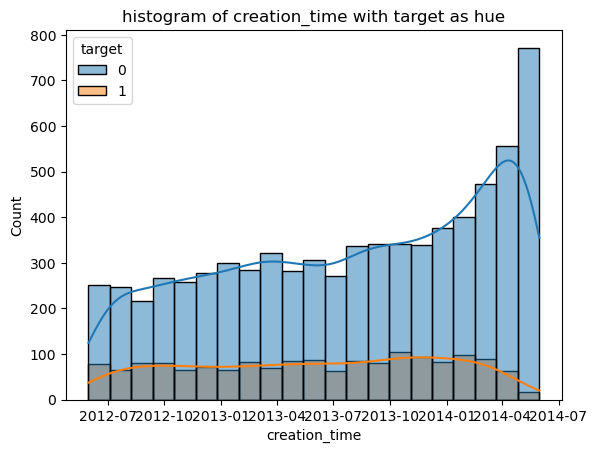

In [10]:
sns.histplot(usr, x='creation_time', hue='target', kde=True)
plt.title('histogram of creation_time with target as hue');
print('We see that the proportion of adpted users decreases over time, especially towards the end')

In [11]:
# usr['creation_day'] = (usr.creation_time - usr.creation_time.min()).dt.days
# use_cols = ['creation_day']

None of the days of the week are significant


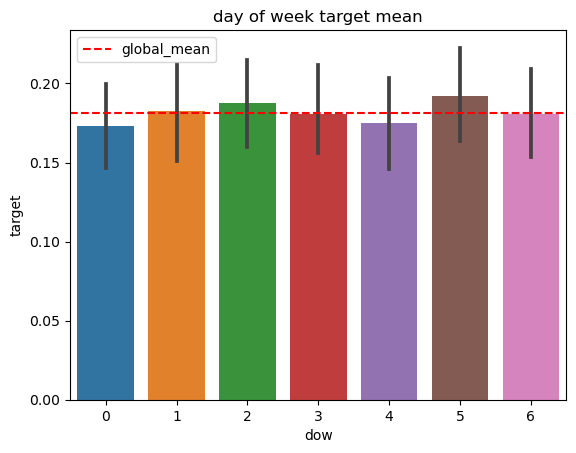

In [12]:
usr['dow'] = usr.creation_time.dt.day_of_week
n_tests = 7
sns.barplot(usr, x='dow', y='target', ci=100 - (5 / n_tests))
plt.axhline(usr.target.mean(), linestyle='--', color='red', label='global_mean')
plt.legend()
plt.title('day of week target mean');
print('None of the days of the week are significant')

None of the days of the month are significant


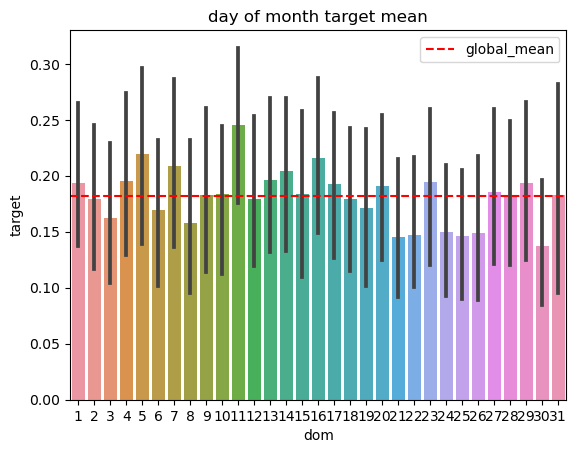

In [13]:
usr['dom'] = usr.creation_time.dt.day
n_tests = 31
sns.barplot(usr, x='dom', y='target', ci=100 - (5 / n_tests))
plt.axhline(usr.target.mean(), linestyle='--', color='red', label='global_mean')
plt.legend()
plt.title('day of month target mean');
print('None of the days of the month are significant')

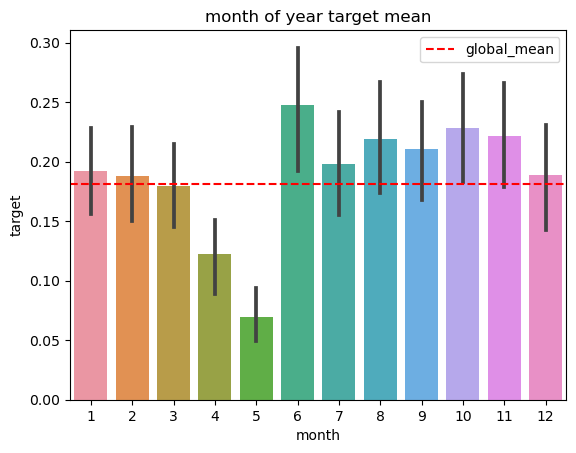

In [14]:
usr['month'] = usr.creation_time.dt.month
n_tests = 12
sns.barplot(usr, x='month', y='target', ci=100 - (5 / n_tests))
plt.axhline(usr.target.mean(), linestyle='--', color='red', label='global_mean')
plt.legend()
plt.title('month of year target mean');

In [15]:
usr['created_in_april'] = usr['month'] == 4
usr['created_in_may'] = usr['month'] == 5
usr['created_in_june'] = usr['month'] == 6
usr['created_in_october'] = usr['month'] == 10
use_cols = ['created_in_april', 'created_in_may', 'created_in_june', 'created_in_october']

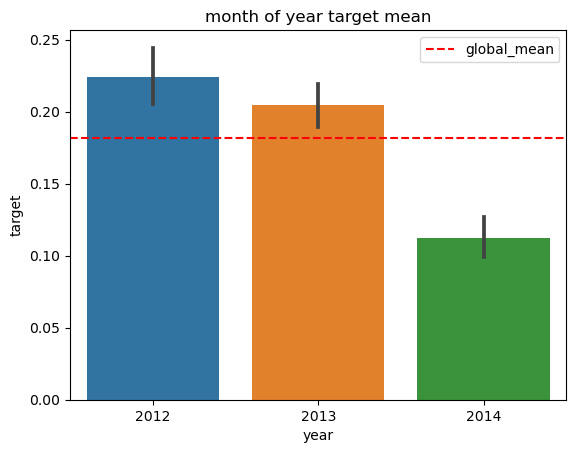

In [16]:
usr['year'] = usr.creation_time.dt.year
n_tests = usr['year'].nunique()
sns.barplot(usr, x='year', y='target', ci=100 - (5 / n_tests))
plt.axhline(usr.target.mean(), linestyle='--', color='red', label='global_mean')
plt.legend()
plt.title('month of year target mean');

In [17]:
tmp = pd.get_dummies(usr['year'], drop_first=True, prefix='signup_year')
tmp.index = usr.index
usr = pd.concat([usr, tmp], axis=1)
use_cols.extend(list(tmp))
use_cols

['created_in_april',
 'created_in_may',
 'created_in_june',
 'created_in_october',
 'signup_year_2013',
 'signup_year_2014']

### email 
Hotmail and yahoo domain names have a target means significantly higher than lower than the global mean. 

In [18]:
usr['domain'] = usr.email.str.split('@').str[-1].str.split('.').str[0]
vc = usr.domain.value_counts()
vc.head(10)

gmail         2930
yahoo         1726
jourrapide     883
gustr          842
cuvox          828
hotmail        803
luque            2
mumdc            2
oqpze            2
xybhi            2
Name: domain, dtype: int64

In [19]:
usr.loc[usr.domain.map(vc < 3), 'domain'] = 'other'
vc = usr.domain.value_counts()
vc.head(10)

gmail         2930
yahoo         1726
jourrapide     883
gustr          842
cuvox          828
other          811
hotmail        803
Name: domain, dtype: int64

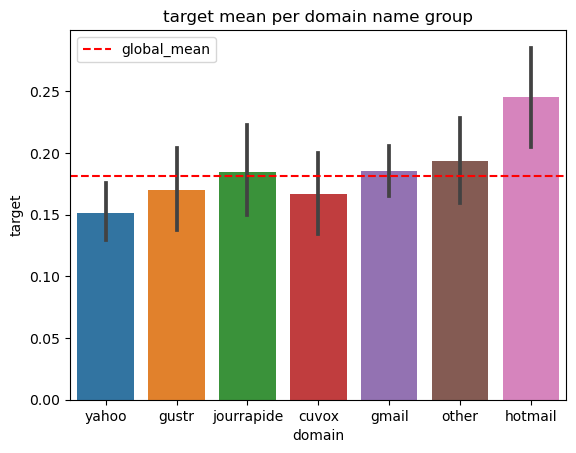

In [20]:
n_tests = usr['domain'].nunique()
sns.barplot(usr, x='domain', y='target', ci=100 - (5 / n_tests))
plt.title('target mean per domain name group')
plt.axhline(usr.target.mean(), linestyle='--', color='red', label='global_mean')
plt.legend();

In [21]:
usr['domain_yahoo'] = usr.domain == 'yahoo'
usr['domain_hotmail'] = usr.domain == 'hotmail'
use_cols.extend(['domain_yahoo', 'domain_hotmail'])

### creation source
"SIGNUP" is the only level that has a target mean that differs significantly from the target.

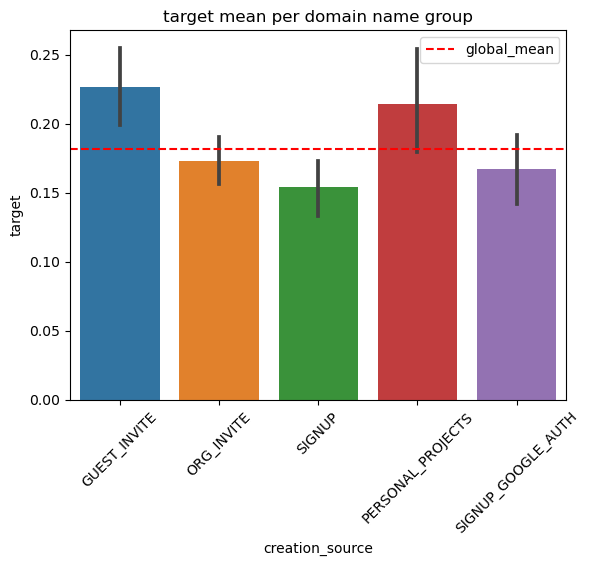

In [22]:
n_tests = usr['creation_source'].nunique()
sns.barplot(usr, x='creation_source', y='target', ci=100 - (5 / n_tests))
plt.title('target mean per domain name group')
plt.axhline(usr.target.mean(), linestyle='--', color='red', label='global_mean')
plt.xticks(rotation=45)
plt.legend();

In [23]:
usr['creation_source_SIGNUP'] = usr.creation_source == 'SIGNUP'
use_cols.append('creation_source_SIGNUP')

### opted_in_to_mailing_list: not significant

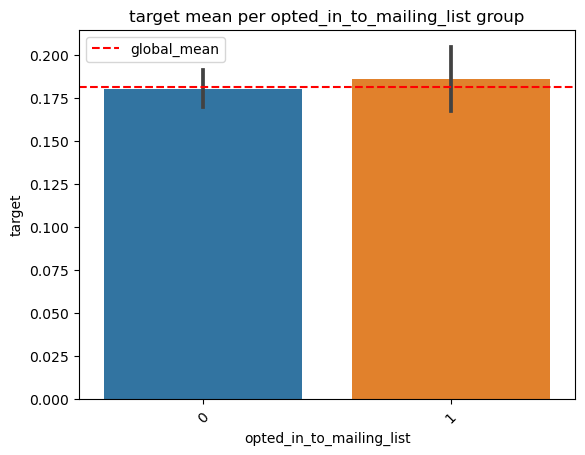

In [24]:
n_tests = usr['opted_in_to_mailing_list'].nunique()
sns.barplot(usr, x='opted_in_to_mailing_list', y='target', ci=100 - (5 / n_tests))
plt.title('target mean per opted_in_to_mailing_list group')
plt.axhline(usr.target.mean(), linestyle='--', color='red', label='global_mean')
plt.xticks(rotation=45)
plt.legend();

### enabled_for_marketing_drip: not significant

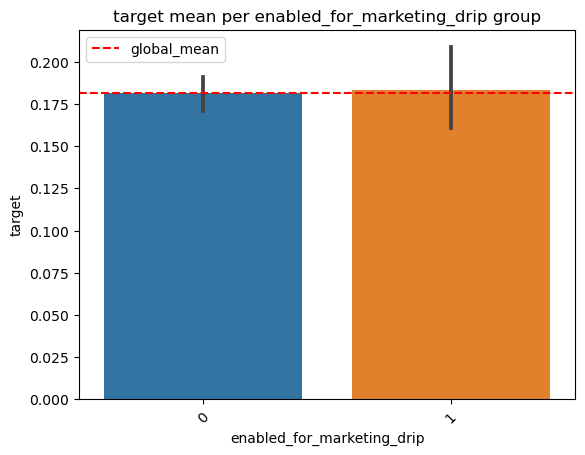

In [25]:
n_tests = usr['enabled_for_marketing_drip'].nunique()
sns.barplot(usr, x='enabled_for_marketing_drip', y='target', ci=100 - (5 / n_tests))
plt.title('target mean per enabled_for_marketing_drip group')
plt.axhline(usr.target.mean(), linestyle='--', color='red', label='global_mean')
plt.xticks(rotation=45)
plt.legend();

### org_id

In [26]:
vc = usr.org_id.value_counts()
vc.head(40)

0     228
1     172
2     150
3     125
4     122
6     102
9      91
7      88
5      87
10     68
8      67
14     66
17     58
12     57
11     56
18     54
20     50
13     50
33     47
15     47
22     46
16     44
24     44
31     44
25     44
27     43
23     43
28     42
21     41
26     40
34     40
30     40
45     38
36     38
53     38
58     38
40     37
32     37
46     36
41     36
Name: org_id, dtype: int64

In [27]:
usr.loc[usr.org_id.map(vc < 50), 'org_id'] = 'other'
vc = usr.org_id.value_counts()
vc.head(20)

other    7132
0         228
1         172
2         150
3         125
4         122
6         102
9          91
7          88
5          87
10         68
8          67
14         66
17         58
12         57
11         56
18         54
13         50
20         50
Name: org_id, dtype: int64

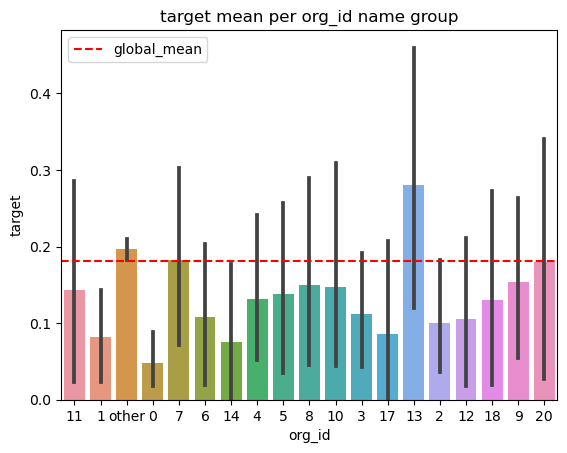

In [28]:
n_tests = usr['org_id'].nunique()
sns.barplot(usr, x='org_id', y='target', ci=100 - (5 / n_tests))
plt.title('target mean per org_id name group')
plt.axhline(usr.target.mean(), linestyle='--', color='red', label='global_mean')
plt.legend();

In [29]:
usr['org_0'] = usr.org_id == 0
usr['org_1'] = usr.org_id == 1
usr['org_2'] = usr.org_id == 2
use_cols.extend(['org_0', 'org_1', 'org_2'])

### invited_by_user_id: not significant
There are so many values that I will map them onto isnan or not. 

In [30]:
usr.invited_by_user_id.nunique()

2229

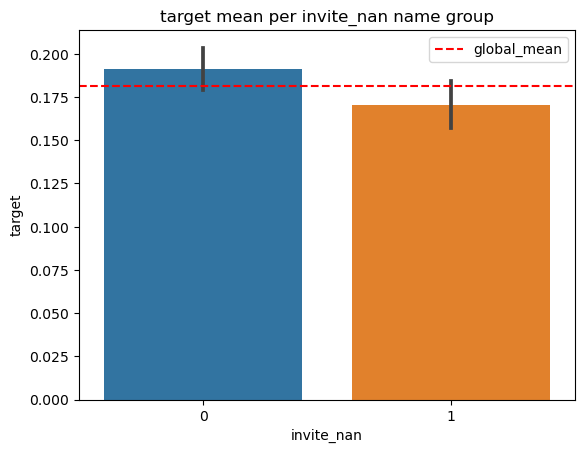

In [31]:
usr['invite_nan'] = usr.invited_by_user_id.isna().astype(int)
n_tests = usr['invite_nan'].nunique()
sns.barplot(usr, x='invite_nan', y='target', ci=100 - (5 / n_tests))
plt.title('target mean per invite_nan name group')
plt.axhline(usr.target.mean(), linestyle='--', color='red', label='global_mean')
plt.legend();

## Features for modeling 
All my features are binary

In [215]:
use_cols

['created_in_april',
 'created_in_may',
 'created_in_june',
 'created_in_october',
 'signup_year_2013',
 'signup_year_2014',
 'domain_yahoo',
 'domain_hotmail',
 'creation_source_SIGNUP',
 'org_0',
 'org_1',
 'org_2']

In [ ]:
['created_in_april',
 'created_in_may',
 'created_in_june',
 'created_in_october',
 'signup_year_2013',
 'signup_year_2014',
 'domain_yahoo',
 'domain_hotmail',
 'creation_source_SIGNUP',
 'org_0',
 'org_1',
 'org_2']

In [33]:
X = usr[use_cols].astype(int)

In [34]:
y = usr['target']

## Checking variance inflation factor
All features have a VIF  

In [78]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values
print(vif)
print('Our features have low multicolinearity')

                  Variable       VIF
0         created_in_april  1.255693
1           created_in_may  1.328760
2          created_in_june  1.059808
3       created_in_october  1.076729
4         signup_year_2013  1.452468
5         signup_year_2014  1.664000
6             domain_yahoo  1.227084
7           domain_hotmail  1.102015
8   creation_source_SIGNUP  1.228204
9                    org_0  1.022958
10                   org_1  1.015382
11                   org_2  1.015350
Our features have low multicolinearity


## Modelling 
I will predict the probability of the target being one, using logloss as my metric

In [189]:
clf = LogisticRegressionCV(scoring='neg_log_loss', cv=5).fit(X, y)

best_C_idx = np.where(clf.Cs_ == clf.C_)[0][0]
print('best C: ', clf.C_)
print('best logloss:', clf.scores_[1][:, best_C_idx].mean())

noreg = LogisticRegression(penalty="none", solver='newton-cg').fit(X, y)
# import statsmodels.api as sm

# Fit a logistic regression model using statsmodels
x_ = sm.add_constant(X)
logit_model = sm.Logit(y, x_)

result = logit_model.fit()

# Get summary statistics, including confidence intervals
summary = result.summary()
coef_table = summary.tables[1]
coef_data = coef_table.data
df = pd.DataFrame(np.array(coef_table.data)[1:, :], 
             columns=np.array(coef_table.data)[0, :]).set_index('').rename(columns={'coef': 'sm_coef'})

clf = LogisticRegressionCV(scoring='neg_log_loss', cv=5).fit(X, y)
best_C_idx = np.where(clf.Cs_ == clf.C_)[0][0]
print('best C: ', clf.C_)
print('best logloss:', clf.scores_[1][:, best_C_idx].mean())
noreg = LogisticRegression(penalty="none", solver='newton-cg').fit(X, y)

df['LRCV_coef'] = np.concatenate((clf.intercept_, clf.coef_[0]))
df['LR_no_reg_coef'] = np.concatenate((noreg.intercept_, noreg.coef_[0]))
df = df[['sm_coef', 'LR_no_reg_coef', 'LRCV_coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]']]
df

best C:  [0.35938137]
best logloss: -0.45722521754574885
Optimization terminated successfully.
         Current function value: 0.455530
         Iterations 7
best C:  [0.35938137]
best logloss: -0.45722521754574885


,sm_coef,LR_no_reg_coef,LRCV_coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,,,
const,-1.1687,-1.168654,-1.181246,0.062,-18.700,0.000,-1.291,-1.046
created_in_april,-0.4010,-0.400969,-0.384261,0.113,-3.536,0.000,-0.623,-0.179
created_in_may,-0.9892,-0.989188,-0.946872,0.130,-7.604,0.000,-1.244,-0.734
created_in_june,0.1684,0.168408,0.166610,0.102,1.644,0.100,-0.032,0.369
created_in_october,0.0511,0.051146,0.054795,0.098,0.522,0.602,-0.141,0.243
signup_year_2013,-0.0250,-0.025042,-0.022048,0.067,-0.372,0.710,-0.157,0.107
signup_year_2014,-0.5309,-0.530897,-0.527305,0.090,-5.880,0.000,-0.708,-0.354
domain_yahoo,-0.1815,-0.181509,-0.179901,0.076,-2.393,0.017,-0.330,-0.033
domain_hotmail,0.3871,0.387080,0.379206,0.090,4.301,0.000,0.211,0.563


We have a few coefficients that are not significant, lets use l1 regularization to find a model that can lower the number of features without sacraficing accuracy.

In [190]:
new_use_cols = [c for c in use_cols if c not in ['created_in_june', 'created_in_october', 'signup_year_2013']]

In [194]:
import statsmodels.api as sm

# Fit a logistic regression model using statsmodels
X_new = usr[new_use_cols].astype(int)
x_ = sm.add_constant(X_new)
logit_model = sm.Logit(y, x_)

result = logit_model.fit()

# Get summary statistics, including confidence intervals
summary = result.summary()
coef_table = summary.tables[1]
coef_data = coef_table.data
df = pd.DataFrame(np.array(coef_table.data)[1:, :], 
             columns=np.array(coef_table.data)[0, :]).set_index('').rename(columns={'coef': 'sm_coef'})

clf = LogisticRegressionCV(scoring='neg_log_loss', cv=5).fit(X_new, y)
best_C_idx = np.where(clf.Cs_ == clf.C_)[0][0]
print('best C: ', clf.C_)
print('best logloss:', clf.scores_[1][:, best_C_idx].mean())
noreg = LogisticRegression(penalty="none", solver='newton-cg').fit(X_new, y)

df['LRCV_coef'] = np.concatenate((clf.intercept_, clf.coef_[0]))
df['LR_no_reg_coef'] = np.concatenate((noreg.intercept_, noreg.coef_[0]))
df = df[['sm_coef', 'LR_no_reg_coef', 'LRCV_coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]']]
df

Optimization terminated successfully.
         Current function value: 0.455703
         Iterations 7
best C:  [0.35938137]
best logloss: -0.4567885822700387


,sm_coef,LR_no_reg_coef,LRCV_coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,,,
const,-1.1596,-1.159649,-1.170122,0.039,-29.671,0.000,-1.236,-1.083
created_in_april,-0.4199,-0.419921,-0.402146,0.112,-3.742,0.000,-0.640,-0.200
created_in_may,-1.0070,-1.006980,-0.963508,0.129,-7.793,0.000,-1.260,-0.754
signup_year_2014,-0.5333,-0.533329,-0.532102,0.074,-7.204,0.000,-0.678,-0.388
domain_yahoo,-0.1818,-0.181753,-0.180190,0.076,-2.396,0.017,-0.330,-0.033
domain_hotmail,0.3894,0.389436,0.381536,0.090,4.329,0.000,0.213,0.566
creation_source_SIGNUP,-0.2561,-0.256097,-0.250903,0.072,-3.574,0.000,-0.397,-0.116
org_0,-1.5756,-1.575591,-1.270379,0.312,-5.058,0.000,-2.186,-0.965
org_1,-0.9944,-0.994384,-0.819816,0.282,-3.524,0.000,-1.547,-0.441


In [202]:
coef = (df['sm_coef'].iloc[1:])

In [214]:
coef.loc[coef.astype('float').abs().sort_values(ascending=False).index]


org_0                        -1.5756
created_in_may               -1.0070
org_1                        -0.9944
org_2                        -0.7872
signup_year_2014             -0.5333
created_in_april             -0.4199
domain_hotmail                0.3894
creation_source_SIGNUP       -0.2561
domain_yahoo                 -0.1818
Name: sm_coef, dtype: object

array([0.09156678, 0.10395496, 0.23873109, ..., 0.10784937, 0.10278755,
       0.04167719])

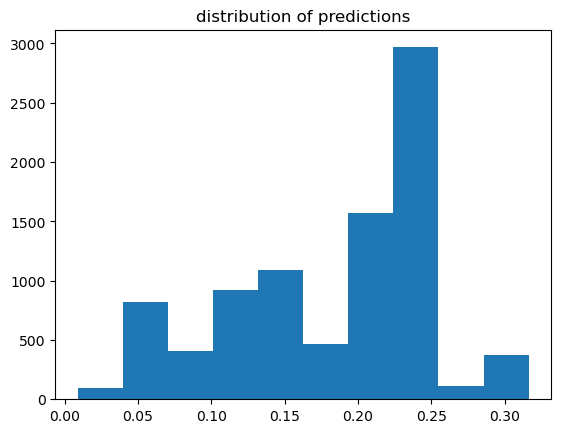

In [231]:
plt.hist(noreg.predict_proba(X_new)[:, 1])
plt.title('distribution of predictions');